In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

from minibatch_discrimination import MiniBatchDiscrimination
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Input dimensions for an MNIST image
MNIST_W = 28
MNIST_H = 28
MNIST_DIM = MNIST_H*MNIST_W
NOISE_DIM = 100
BATCH_SIZE = 20
LEARN_RATE = 1e-3
MAX_EPOCH = 20

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0,),(1,))])
trainset = torchvision.datasets.MNIST(root = '../data_MNIST',train = True, download = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
dataiter = iter(trainloader)

In [4]:
# Define the generator and discriminator networks
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.lin1 = nn.Linear(NOISE_DIM, 192)
        self.lin2 = nn.Linear(192, MNIST_DIM)

    def forward(self, x):
        x = F.leaky_relu(self.lin1(x),0.1)
        # x = self.bat1(x)
        x = F.sigmoid(self.lin2(x))
        return x
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.lin1 = nn.Linear(MNIST_DIM, 128)
        self.mbd1 = MiniBatchDiscrimination(128, 64, 50, BATCH_SIZE)
        self.lin2 = nn.Linear(192, 1)

    def forward(self, x):
        x = F.leaky_relu(self.lin1(x),0.1)        
        x = F.sigmoid(self.lin2( torch.cat((x, self.mbd1(x)),dim=1) ))
        return x

In [5]:
# Instantiate a generator and discriminator and start training
smooth_labels = 1
gen1 = Generator()
dis1 = Discriminator()
gen_optimizer = optim.Adam(gen1.parameters(), lr = LEARN_RATE)
dis_optimizer = optim.Adam(dis1.parameters(), lr = LEARN_RATE)

criterion_dis = nn.BCELoss()
criterion_gen = nn.BCELoss()

In [6]:
LEARN_RATE = 1e-4
for epoch in range(MAX_EPOCH):
    dataiter = iter(trainloader)
    for i, data in enumerate(dataiter):
        true_im, _ = data
        dis_optimizer.zero_grad()
        gen_optimizer.zero_grad()
        # Forward pass 'BATCH_SIZE' number of noise vectors through Generator
        noise_outputs = gen1(Variable(torch.randn(BATCH_SIZE,NOISE_DIM)))
        # Obtain 'BATCH_SIZE' number of true samples
        true_vec = true_im.view(-1,MNIST_DIM)
              
        # Forward pass "false" and true samples through the discriminator
        # and calculate the respective terms of discriminator loss
        if smooth_labels == 0:
            dis_true_loss = criterion_dis(dis1(Variable(true_vec)),Variable(torch.ones([BATCH_SIZE,1])))
            dis_false_loss = criterion_dis(dis1(noise_outputs),Variable(torch.zeros([BATCH_SIZE,1])))
        else:
            dis_true_loss = criterion_dis(dis1(Variable(true_vec)),Variable(0.9*torch.ones([BATCH_SIZE,1])))
            dis_false_loss = criterion_dis(dis1(noise_outputs),Variable(0.1*torch.ones([BATCH_SIZE,1])))
            
        # Calculate discriminator loss and backprop on discriminator params
        dis_loss = (dis_true_loss + dis_false_loss)
        dis_loss.backward()
        dis_optimizer.step()

        ## Generator update step
        dis_optimizer.zero_grad()
        gen_optimizer.zero_grad()
        
        # Forward pass 'BATCH_SIZE' number of noise vectors through Generator, and the outputs through Discriminator		
        noise_outputs = gen1(Variable(torch.randn(BATCH_SIZE,NOISE_DIM)))

        # Calculate generator loss and backprop on generator params
        if smooth_labels == 0:
            gen_loss = criterion_gen(dis1(noise_outputs),Variable(torch.ones([BATCH_SIZE,1])))
        else:
            gen_loss = criterion_gen(dis1(noise_outputs),Variable(0.9*torch.ones([BATCH_SIZE,1])))    
        gen_loss.backward()
        gen_optimizer.step()


        if i % 100 == 0:
            print('iter: %3d dis_loss: %.3f gen_loss: %.3f  ' % (i, dis_loss.data, gen_loss.data) )
    
    print('One Epoch completed')
    # Should save the model at this checkpoint
    

iter:   0 dis_loss: 1.382 gen_loss: 1.066  
iter: 100 dis_loss: 0.922 gen_loss: 1.556  
iter: 200 dis_loss: 0.694 gen_loss: 2.217  
iter: 300 dis_loss: 0.688 gen_loss: 2.267  
iter: 400 dis_loss: 0.669 gen_loss: 2.181  
iter: 500 dis_loss: 0.668 gen_loss: 2.111  
iter: 600 dis_loss: 0.659 gen_loss: 1.948  
iter: 700 dis_loss: 0.656 gen_loss: 2.031  
iter: 800 dis_loss: 0.660 gen_loss: 2.163  
iter: 900 dis_loss: 0.736 gen_loss: 2.084  
iter: 1000 dis_loss: 0.706 gen_loss: 2.291  
iter: 1100 dis_loss: 0.664 gen_loss: 2.363  
iter: 1200 dis_loss: 0.685 gen_loss: 2.149  
iter: 1300 dis_loss: 0.666 gen_loss: 2.261  
iter: 1400 dis_loss: 0.681 gen_loss: 2.142  
iter: 1500 dis_loss: 0.698 gen_loss: 2.378  
iter: 1600 dis_loss: 0.684 gen_loss: 2.376  
iter: 1700 dis_loss: 0.682 gen_loss: 2.072  
iter: 1800 dis_loss: 0.681 gen_loss: 2.106  
iter: 1900 dis_loss: 0.694 gen_loss: 2.027  
iter: 2000 dis_loss: 0.765 gen_loss: 2.011  
iter: 2100 dis_loss: 0.675 gen_loss: 1.956  
iter: 2200 dis_loss:

iter: 100 dis_loss: 1.208 gen_loss: 1.235  
iter: 200 dis_loss: 1.063 gen_loss: 1.378  
iter: 300 dis_loss: 0.942 gen_loss: 1.403  
iter: 400 dis_loss: 0.963 gen_loss: 1.020  
iter: 500 dis_loss: 0.954 gen_loss: 1.242  
iter: 600 dis_loss: 1.036 gen_loss: 1.372  
iter: 700 dis_loss: 0.931 gen_loss: 1.001  
iter: 800 dis_loss: 0.980 gen_loss: 1.355  
iter: 900 dis_loss: 1.104 gen_loss: 1.596  
iter: 1000 dis_loss: 1.036 gen_loss: 1.260  
iter: 1100 dis_loss: 1.020 gen_loss: 1.201  
iter: 1200 dis_loss: 1.048 gen_loss: 1.077  
iter: 1300 dis_loss: 1.168 gen_loss: 1.150  
iter: 1400 dis_loss: 1.142 gen_loss: 1.217  
iter: 1500 dis_loss: 0.946 gen_loss: 1.558  
iter: 1600 dis_loss: 1.082 gen_loss: 1.021  
iter: 1700 dis_loss: 1.128 gen_loss: 1.290  
iter: 1800 dis_loss: 1.132 gen_loss: 1.193  
iter: 1900 dis_loss: 1.046 gen_loss: 1.228  
iter: 2000 dis_loss: 1.007 gen_loss: 1.152  
iter: 2100 dis_loss: 0.919 gen_loss: 1.378  
iter: 2200 dis_loss: 0.963 gen_loss: 1.217  
iter: 2300 dis_loss

iter: 200 dis_loss: 1.123 gen_loss: 1.065  
iter: 300 dis_loss: 1.154 gen_loss: 1.014  
iter: 400 dis_loss: 1.138 gen_loss: 0.873  
iter: 500 dis_loss: 1.004 gen_loss: 0.955  
iter: 600 dis_loss: 1.007 gen_loss: 1.353  
iter: 700 dis_loss: 1.193 gen_loss: 0.850  
iter: 800 dis_loss: 1.106 gen_loss: 1.121  
iter: 900 dis_loss: 1.124 gen_loss: 0.968  
iter: 1000 dis_loss: 1.164 gen_loss: 1.177  
iter: 1100 dis_loss: 1.125 gen_loss: 0.955  
iter: 1200 dis_loss: 1.192 gen_loss: 1.092  
iter: 1300 dis_loss: 1.268 gen_loss: 1.253  
iter: 1400 dis_loss: 0.992 gen_loss: 0.987  
iter: 1500 dis_loss: 1.026 gen_loss: 1.082  
iter: 1600 dis_loss: 1.076 gen_loss: 1.118  
iter: 1700 dis_loss: 1.125 gen_loss: 1.119  
iter: 1800 dis_loss: 0.947 gen_loss: 1.187  
iter: 1900 dis_loss: 1.069 gen_loss: 1.250  
iter: 2000 dis_loss: 1.079 gen_loss: 1.305  
iter: 2100 dis_loss: 1.137 gen_loss: 1.172  
iter: 2200 dis_loss: 1.062 gen_loss: 1.193  
iter: 2300 dis_loss: 1.191 gen_loss: 1.005  
iter: 2400 dis_los

iter: 300 dis_loss: 1.063 gen_loss: 1.216  
iter: 400 dis_loss: 1.129 gen_loss: 1.164  
iter: 500 dis_loss: 0.963 gen_loss: 0.995  
iter: 600 dis_loss: 1.011 gen_loss: 1.202  
iter: 700 dis_loss: 1.140 gen_loss: 0.977  
iter: 800 dis_loss: 1.044 gen_loss: 1.122  
iter: 900 dis_loss: 1.082 gen_loss: 1.258  
iter: 1000 dis_loss: 0.997 gen_loss: 1.019  
iter: 1100 dis_loss: 1.101 gen_loss: 1.118  
iter: 1200 dis_loss: 1.159 gen_loss: 0.918  
iter: 1300 dis_loss: 1.096 gen_loss: 1.067  
iter: 1400 dis_loss: 1.322 gen_loss: 1.312  
iter: 1500 dis_loss: 1.040 gen_loss: 1.217  
iter: 1600 dis_loss: 1.091 gen_loss: 1.264  
iter: 1700 dis_loss: 1.240 gen_loss: 1.195  
iter: 1800 dis_loss: 1.188 gen_loss: 0.939  
iter: 1900 dis_loss: 0.994 gen_loss: 1.030  
iter: 2000 dis_loss: 1.111 gen_loss: 1.331  
iter: 2100 dis_loss: 1.133 gen_loss: 1.582  
iter: 2200 dis_loss: 1.087 gen_loss: 1.041  
iter: 2300 dis_loss: 1.230 gen_loss: 0.999  
iter: 2400 dis_loss: 1.064 gen_loss: 1.399  
iter: 2500 dis_lo

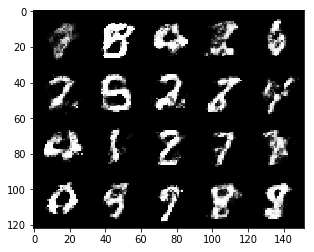

In [12]:
# Look at the generated images
false_vec = gen1(Variable(torch.randn(20,NOISE_DIM)*2))
false_im = false_vec.view(-1,1,28,28)
false_im_grid = torchvision.utils.make_grid(false_im.data,nrow = 5)
np_im_grid = false_im_grid.numpy()
plt.imshow(np.transpose(np_im_grid,(1,2,0)))